In [1]:
# get dataset
import csv
import numpy as np
from datasets import load_dataset
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
dataset = load_dataset("tweet_eval", "irony")

In [2]:
dataset['train']['text'][0:5] #check fist 5

['seeing ppl walking w/ crutches makes me really excited for the next 3 weeks of my life',
 'look for the girl with the broken smile, ask her if she wants to stay while, and she will be loved. 💕🎵',
 'Now I remember why I buy books online @user #servicewithasmile',
 '@user @user So is he banded from wearing the clothes?  #Karma',
 'Just found out there are Etch A Sketch apps.  #oldschool #notoldschool']

In [3]:
dataset['train']['label'][0:5]

[1, 0, 1, 1, 1]

In [4]:
df = pd.DataFrame(dataset['train'])
df.head(10)

,text,label
0,seeing ppl walking w/ crutches makes me really...,1
1,"look for the girl with the broken smile, ask h...",0
2,Now I remember why I buy books online @user #s...,1
3,@user @user So is he banded from wearing the c...,1
4,Just found out there are Etch A Sketch apps. ...,1
5,"Hey what do you know, one of the witnesses sup...",1
6,@user on stage at #flzjingleball at the @user ...,0
7,You know it's going to be a great day when you...,1
8,Halfway thorough my workday ... Woooo,1
9,Would like to thank my nephew for giving me hi...,1


In [5]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import AutoConfig
#get the bert pretrained model
task = 'irony'
model_name = f"cardiffnlp/twitter-roberta-base-{task}"
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_name, config= config)
#model.save_pretrained(model_name)

In [6]:


#preproc
def preproc(dat):
    return tokenizer(dat["text"], truncation=True, padding="max_length", max_length=128)
proc_dat = dataset.map(preproc, batched=True)


In [7]:
proc_dat.set_format("torch", columns=["input_ids", "attention_mask", "label"]) #convert for model

In [8]:
from transformers import TrainingArguments, Trainer
#make args for the model
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=32,  #decent batch size
    logging_dir="./logs",
    eval_strategy="no",  # no eval for training
    save_strategy="no", #no saving bc im printing to pdf
)

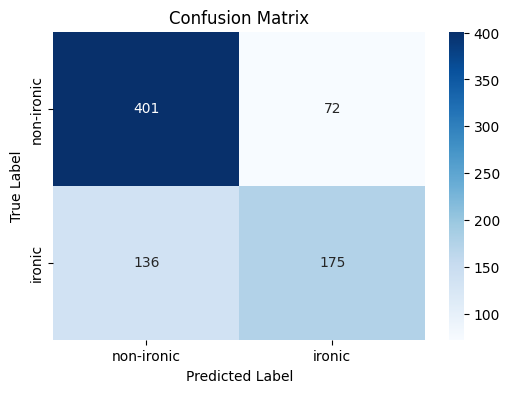

Test Results: {'eval_loss': 0.5614769458770752, 'eval_model_preparation_time': 0.003, 'eval_accuracy': 0.7346938775510204, 'eval_f1': 0.6272401433691757, 'eval_precision': 0.708502024291498, 'eval_recall': 0.5627009646302251, 'eval_runtime': 6.6032, 'eval_samples_per_second': 118.73, 'eval_steps_per_second': 3.786}


In [9]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, recall_score
def accs(pred):   #get obj of pred metrics
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    cm = confusion_matrix(labels, preds, labels=[0, 1])
    plt.figure(figsize=(6, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=["non-ironic", "ironic"],
        yticklabels=["non-ironic", "ironic"],
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    plt.show()
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=proc_dat["test"],
    compute_metrics=accs,
)
test_results = trainer.evaluate()
print("Test Results:", test_results)
##THESE RESULTS ARE CONSISTENT WITH THE CITED PAPER RESULTS FOR ROBERT (.62 F1)

In [10]:
import os
from groq import Groq
os.environ["GROQ_API_KEY"] = #API KEYS ARE FREE TO GENERATE ON THE GROQ WEBSITE
client = Groq()  #llama-3.1-8b-instant
prompt_template = """Given the following post, classify it as "ironic" or "non-ironic". Irony involves saying something that contrasts with the intended meaning, often for the purpose of humour. Provide only the label ("ironic" or "non-ironic") as your response.
Tweet: {tweet}"""
def classify_tweet(tweet, model="llama-3.1-8b-instant"): #llama-3.1-8b-instant model
    prompt = prompt_template.format(tweet=tweet)
    try:
        response = client.chat.completions.create(     #get model response
            messages=[{"role": "user", "content": prompt}],
            model=model,
            max_tokens=10,
            temperature=0.0  # Deterministic output
        )
        prediction = response.choices[0].message.content.strip().lower()
        return prediction
    except Exception as e:
        print(f"Error processing tweet: {e}")
        return None



In [11]:
predictions = []
true_labels = []
from tqdm.notebook import tqdm #make progress counter
tdat =dataset['test']
#print(tdat)
citer = 0
for i in tqdm(range(len(tdat))):
    item = tdat[i]
    citer+=1
    #print(citer)
    #print(item['text'])
    tweet = item['text']
    true_label = item['label']  # 1 for ironic, 0 for non-ironic
    
    # Get prediction from Groq API
    pred = classify_tweet(tweet)
    #print(pred)
    #print(true_label)
    if pred in ["ironic", "non-ironic"]:
        predictions.append(1 if pred == "ironic" else 0)
        true_labels.append(true_label)
    else:
        print(f"Invalid prediction for tweet: {tweet}, Prediction: {pred}")



  0%|          | 0/784 [00:00<?, ?it/s]

In [12]:
# convert for sklearn
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# sklearn metrics
precision, rec, f1, _ = precision_recall_fscore_support(true_labels,predictions, average="binary")

acc = accuracy_score(true_labels, predictions)

print(f"\nMetrics Summary:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")



Metrics Summary:
Accuracy: 0.6913
Precision: 0.5772
Recall: 0.8296
F1 Score: 0.6807


In [13]:

cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
print(cm)

[[284 189]
 [ 53 258]]


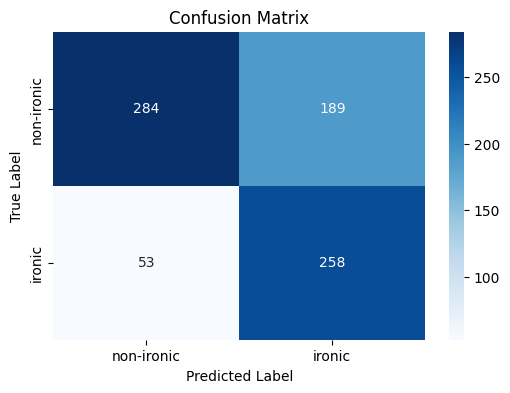

In [14]:

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["non-ironic", "ironic"],
    yticklabels=["non-ironic", "ironic"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

In [47]:
import re
client = Groq()  #deepseek-r1-distill-llama-70b
prompt_template = """Given the following post, classify it as "ironic" or "non-ironic". Irony involves saying something that contrasts with the intended meaning, often for the purpose of humour. Provide only <answer>"ironic" or "non-ironic"</answer> as your response.
Tweet: {tweet}
RESPOND WITH <answer>ironic||non-ironic</answer> ONLY
"""
def classify_tweet(tweet, model="deepseek-r1-distill-llama-70b"): #deepseek-r1-distill-llama-70b
    prompt = prompt_template.format(tweet=tweet)
    try:
        response = client.chat.completions.create(     #get model response
            messages=[{"role": "user", "content": prompt}],
            model=model,
            max_tokens=1000, #due to insistense on showing thinking process
            temperature=0.0  # Deterministic output
        )
        #print(response.choices[0].message.content.strip().lower())
        prediction = response.choices[0].message.content.strip().lower().split('<answer>')[1]
            #had to modify this because the model insits on outputting its thinking
        #print(prediction)
        rege = "(non-ironic|ironic)"
        match = re.search(rege, prediction)
        #print(match.group(1).lower())
        if match:
            prediction = match.group(1).lower()
        else:
            prediction = None
            
            print(f"Could not extract answer from response: {prediction}")
        return prediction
    except Exception as e:
        print(response.choices[0].message.content.strip().lower())
        print(f"Error processing tweet: {e}")
        return None
predictions = []
true_labels = []
from tqdm.notebook import tqdm #make progress counter
tdat =dataset['test']
#print(tdat)
citer = 0
for i in tqdm(range(len(tdat))):
    item = tdat[i]
    citer+=1
    #print(citer)
    #print(item['text'])
    tweet = item['text']
    true_label = item['label']  # 1 for ironic, 0 for non-ironic
    
    # Get prediction from Groq API
    pred = classify_tweet(tweet)
    #print(pred)
    #print(true_label)
    if pred in ["ironic", "non-ironic"]:
        predictions.append(1 if pred == "ironic" else 0)
        true_labels.append(true_label)
    else:
        print(f"Invalid prediction for tweet: {tweet}, Prediction: {pred}")
 


  0%|          | 0/784 [00:00<?, ?it/s]

In [48]:
# convert for sklearn
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# sklearn metrics
precision, rec, f1, _ = precision_recall_fscore_support(true_labels,predictions, average="binary")

acc = accuracy_score(true_labels, predictions)

print(f"\nMetrics Summary:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")



Metrics Summary:
Accuracy: 0.7895
Precision: 0.6580
Recall: 0.9775
F1 Score: 0.7865


In [49]:
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
print(cm)

[[315 158]
 [  7 304]]


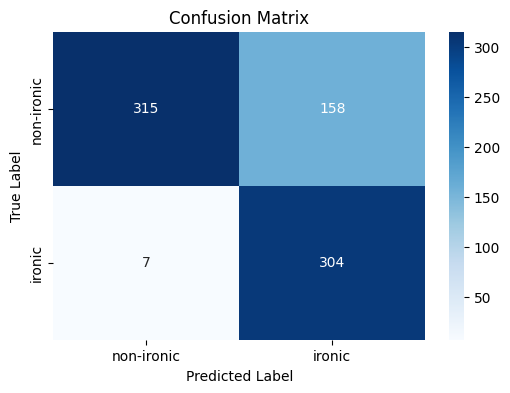

In [50]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["non-ironic", "ironic"],
    yticklabels=["non-ironic", "ironic"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

In [51]:
client = Groq()  # gemma2-9b-it
prompt_template = """Given the following post, classify it as "ironic" or "non-ironic". Irony involves saying something that contrasts with the intended meaning, often for the purpose of humour. Provide only the label ("ironic" or "non-ironic") as your response.
Tweet: {tweet}"""
def classify_tweet(tweet, model="gemma2-9b-it"): #gemma2-9b-it
    prompt = prompt_template.format(tweet=tweet)
    try:
        response = client.chat.completions.create(     #get model response
            messages=[{"role": "user", "content": prompt}],
            model=model,
            max_tokens=10,
            temperature=0.0  # Deterministic output
        )
        prediction = response.choices[0].message.content.strip().lower()
        return prediction
    except Exception as e:
        print(f"Error processing tweet: {e}")
        return None
predictions = []
true_labels = []
from tqdm.notebook import tqdm #make progress counter
tdat =dataset['test']
#print(tdat)
citer = 0
for i in tqdm(range(len(tdat))):
    item = tdat[i]
    citer+=1
    #print(citer)
    #print(item['text'])
    tweet = item['text']
    true_label = item['label']  # 1 for ironic, 0 for non-ironic
    
    # Get prediction from Groq API
    pred = classify_tweet(tweet)
    #print(pred)
    #print(true_label)
    if pred in ["ironic", "non-ironic"]:
        predictions.append(1 if pred == "ironic" else 0)
        true_labels.append(true_label)
    else:
        print(f"Invalid prediction for tweet: {tweet}, Prediction: {pred}")



  0%|          | 0/784 [00:00<?, ?it/s]

In [52]:
# convert for sklearn
predictions = np.array(predictions)
true_labels = np.array(true_labels)

# sklearn metrics
precision, rec, f1, _ = precision_recall_fscore_support(true_labels,predictions, average="binary")

acc = accuracy_score(true_labels, predictions)

print(f"\nMetrics Summary:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")



Metrics Summary:
Accuracy: 0.5191
Precision: 0.4520
Recall: 1.0000
F1 Score: 0.6226


In [53]:
cm = confusion_matrix(true_labels, predictions, labels=[0, 1])
print(cm)

[[ 96 377]
 [  0 311]]


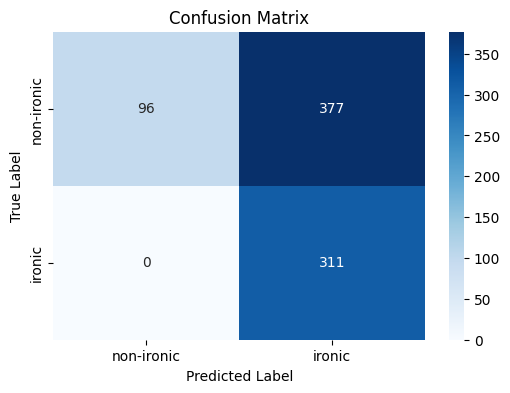

In [54]:
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["non-ironic", "ironic"],
    yticklabels=["non-ironic", "ironic"],
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()